✓ 30 ficheiros encontrados


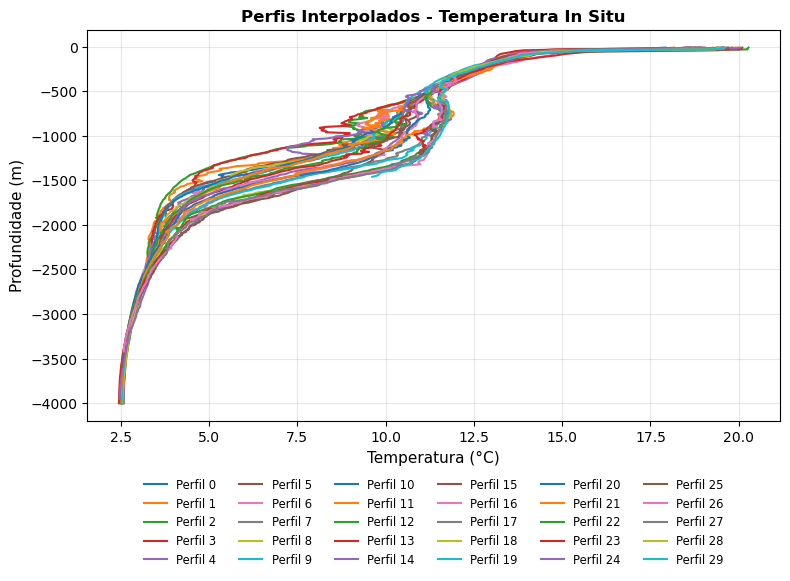

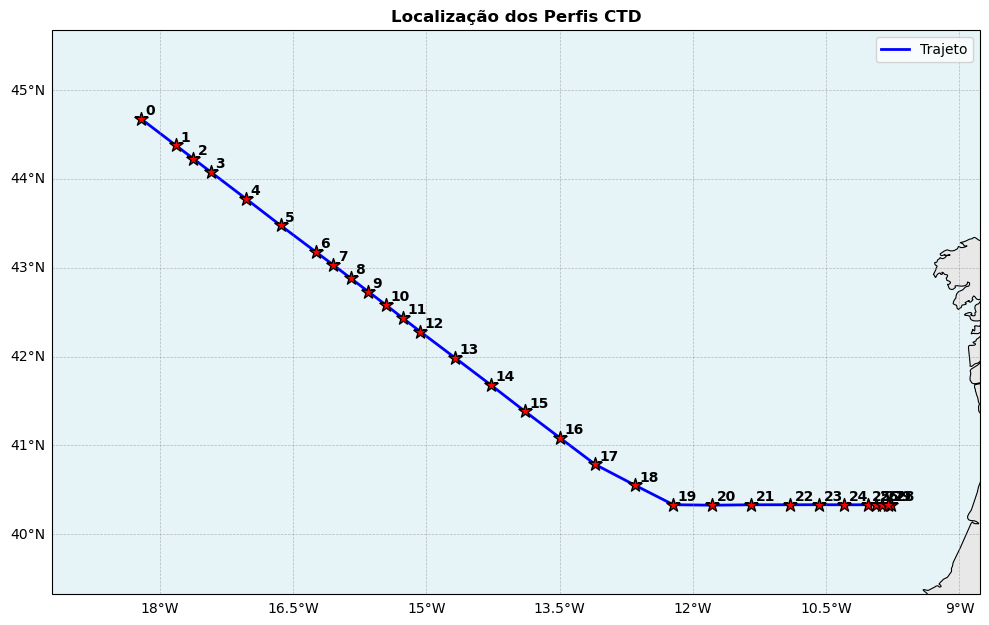

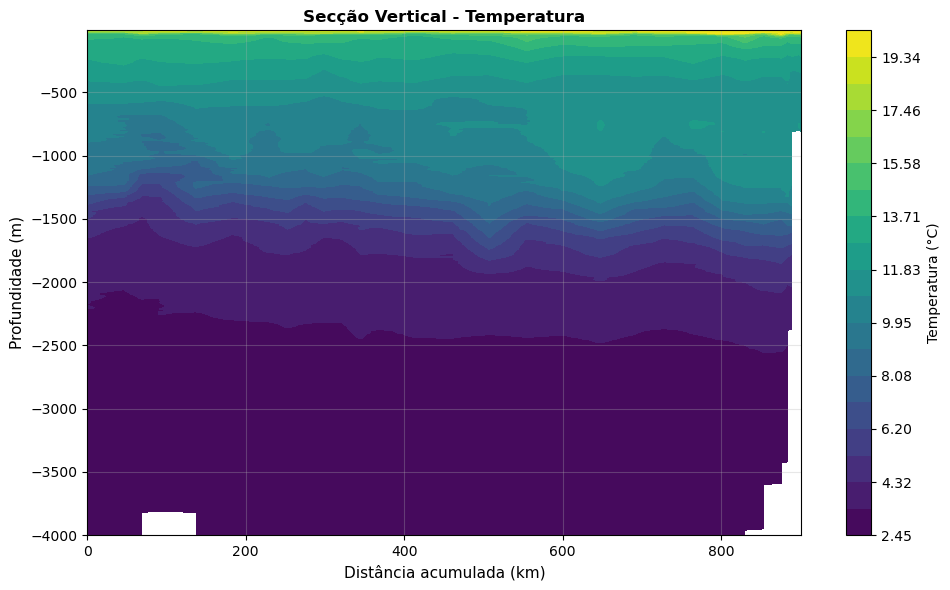

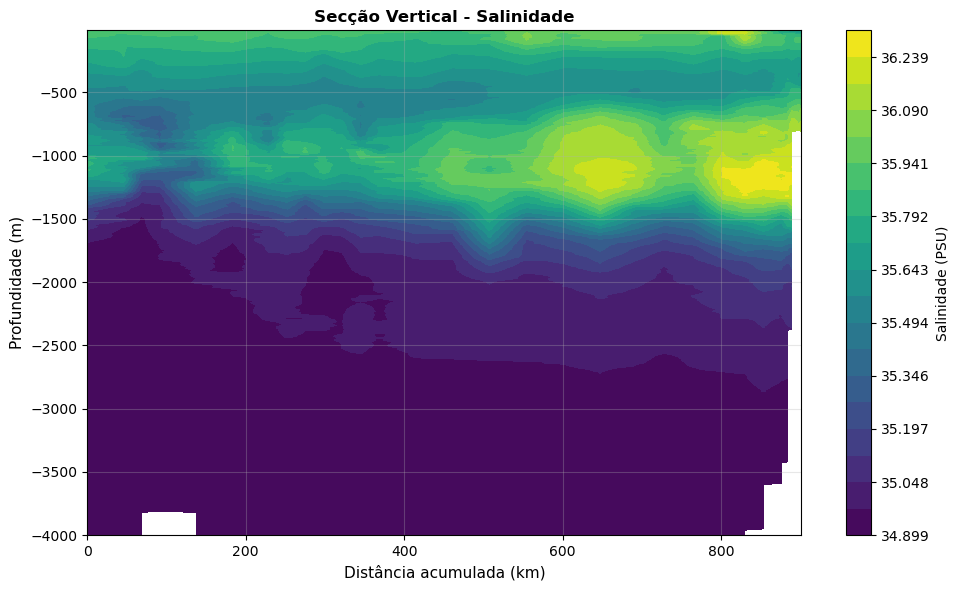

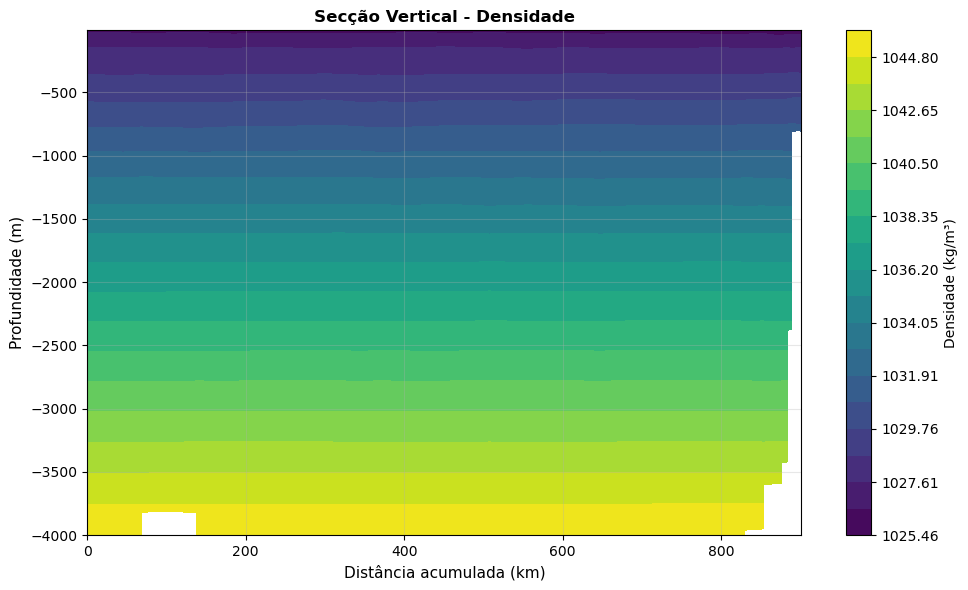


ANÁLISE DE MISTURA - TRIÂNGULO (ENACW16, MW, NEADWL)

Ponto    T(°C)    S(PSU)    P(dbar)   | ENACW16%   MW%        NEADWL%   
----------------------------------------------------------------------
----------------------------------------------------------------------

📊 Pontos dentro do triângulo: 544/4920 (11.1%)

📈 Percentagens médias de contribuição:
   ENACW16: 37.0%
   MW:      16.2%
   NEADWL:  46.8%



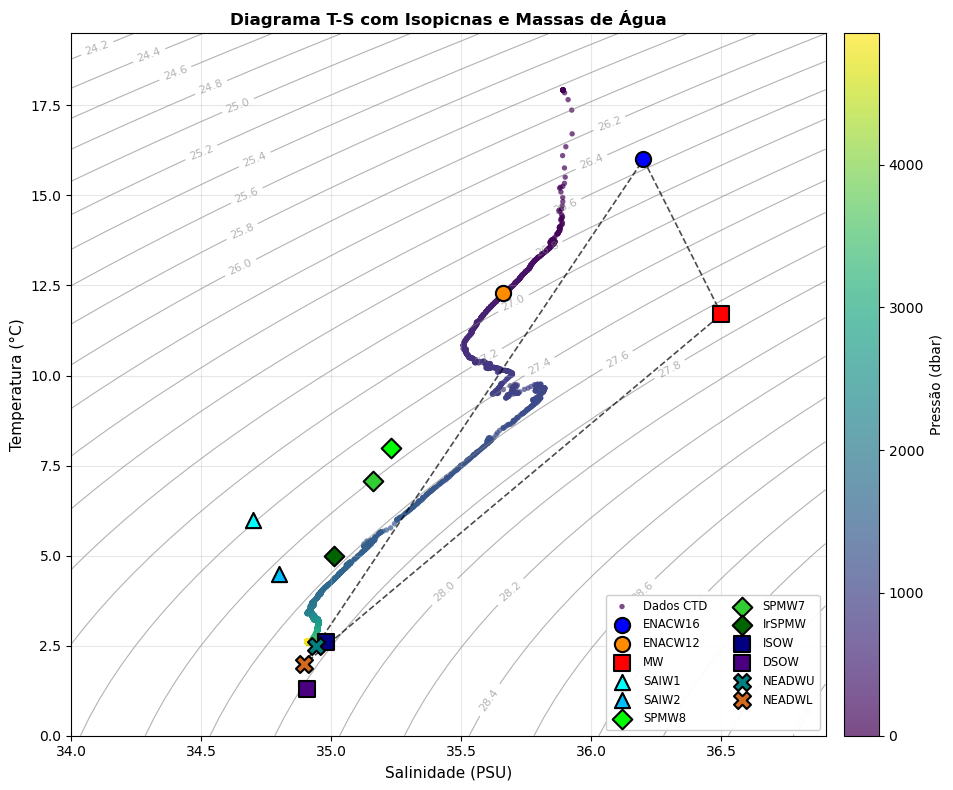

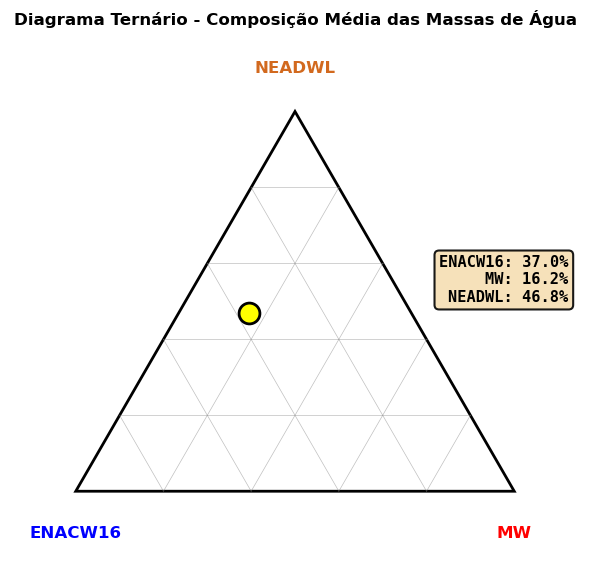


✓ Gráfico RGB: 544 pontos coloridos por mistura de massas



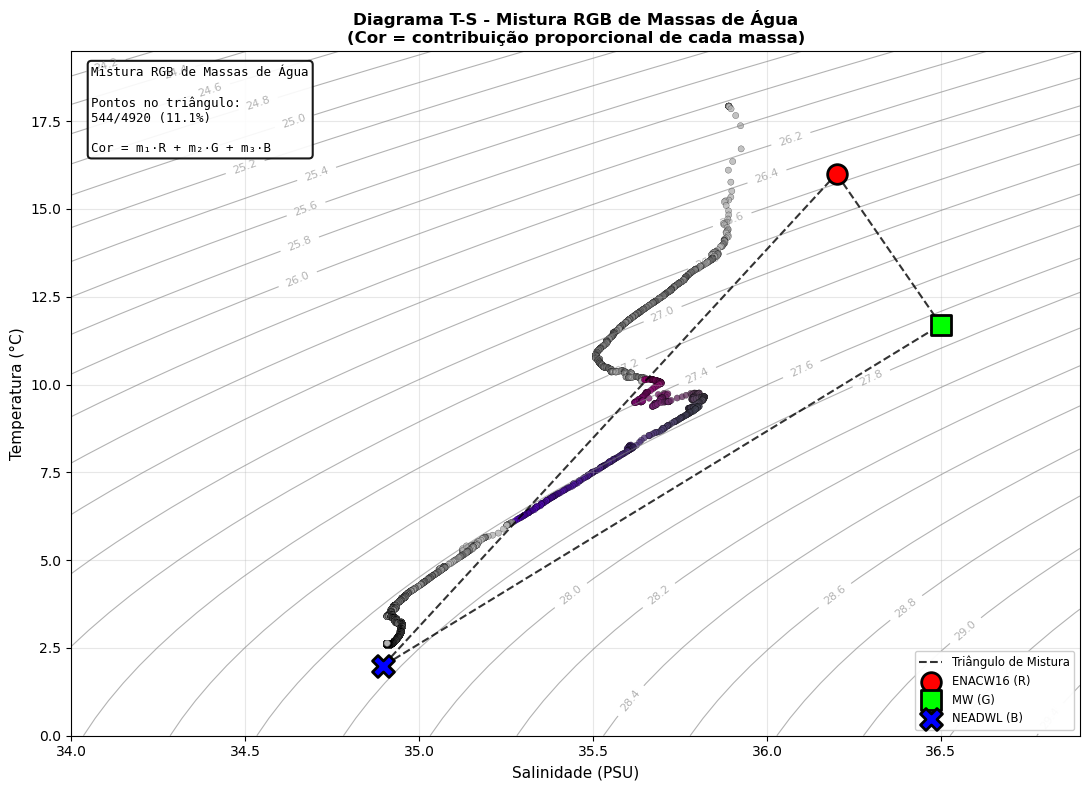

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Oceanografia - Perfis, Secções e Diagramas TS
Autor: João
"""

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import gsw
import glob, os
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl import ticker as cticker


# ============================================================================
# CONFIGURAÇÕES GLOBAIS
# ============================================================================

Znew = np.linspace(10, 4000, 400)

# Estilos para massas de água (com RGB adicionado)
MA_ESTILO = {
    'ENACW16': {'cor': 'blue',       'marker': 'o', 'size': 120, 'rgb': (1.0, 0.0, 0.0)},
    'ENACW12': {'cor': 'darkorange', 'marker': 'o', 'size': 120, 'rgb': (1.0, 0.5, 0.0)},
    'MW':      {'cor': 'red',        'marker': 's', 'size': 120, 'rgb': (0.0, 1.0, 0.0)},
    'SAIW1':   {'cor': 'cyan',       'marker': '^', 'size': 120, 'rgb': (0.0, 1.0, 1.0)},
    'SAIW2':   {'cor': 'deepskyblue','marker': '^', 'size': 120, 'rgb': (0.0, 0.7, 1.0)},
    'SPMW8':   {'cor': 'lime',       'marker': 'D', 'size': 100, 'rgb': (0.5, 1.0, 0.0)},
    'SPMW7':   {'cor': 'limegreen',  'marker': 'D', 'size': 100, 'rgb': (0.3, 0.8, 0.0)},
    'IrSPMW':  {'cor': 'darkgreen',  'marker': 'D', 'size': 100, 'rgb': (0.0, 0.5, 0.0)},
    'LSW':     {'cor': 'magenta',    'marker': 'v', 'size': 120, 'rgb': (1.0, 0.0, 1.0)},
    'ISOW':    {'cor': 'navy',       'marker': 's', 'size': 120, 'rgb': (0.0, 0.0, 0.5)},
    'DSOW':    {'cor': 'indigo',     'marker': 's', 'size': 120, 'rgb': (0.3, 0.0, 0.5)},
    'NEADWU':  {'cor': 'teal',       'marker': 'X', 'size': 150, 'rgb': (0.0, 0.5, 0.5)},
    'NEADWL':  {'cor': 'chocolate',  'marker': 'X', 'size': 150, 'rgb': (0.0, 0.0, 1.0)}
}

# ============================================================================
# FUNÇÕES DE LEITURA E CÁLCULO
# ============================================================================

def ler_perfis(ncf, Znew):
    """Lê perfis de temperatura e salinidade de ficheiros NetCDF."""
    n = len(ncf)
    la = np.zeros(n)
    lo = np.zeros(n)
    Ti = np.zeros(n)
    Te = np.zeros([n, len(Znew)])
    Se = np.zeros([n, len(Znew)])

    for k, fi in enumerate(ncf):
        nc = Dataset(fi, 'r')
        la[k] = nc.variables['lat'][:]
        lo[k] = nc.variables['lon'][:]
        Ti[k] = nc.variables['time'][:]
        P = nc.variables['Pressure'][:]
        T = nc.variables['Temperature'][:]
        S = nc.variables['Salinity'][:]
        
        Te[k, :] = np.interp(Znew, P, T, left=np.nan, right=np.nan)
        Se[k, :] = np.interp(Znew, P, S, left=np.nan, right=np.nan)
        nc.close()

    return la, lo, Ti, Te, Se


def calcular_densidade(Te, Se, Znew, lo, la):
    """Calcula densidade in situ usando GSW."""
    Rho = np.zeros_like(Te)
    for i in range(Te.shape[0]):
        SA = gsw.SA_from_SP(Se[i, :], Znew, lo[i], la[i])
        CT = gsw.CT_from_t(SA, Te[i, :], Znew)
        Rho[i, :] = gsw.rho(SA, CT, Znew)
    return Rho


def ler_massas_agua(ficheiro="Pontos_MA.txt"):
    """Lê pontos característicos de massas de água."""
    grupo = defaultdict(lambda: {'sal': [], 'temp': []})
    
    try:
        with open(ficheiro, "r") as f:
            for line in f:
                line = line.strip()
                if not line or line.startswith('#'):
                    continue
                
                parts = line.split()
                if len(parts) >= 3:
                    try:
                        nome = parts[0]
                        temp = float(parts[1])
                        sal = float(parts[2])
                        grupo[nome]['sal'].append(sal)
                        grupo[nome]['temp'].append(temp)
                    except ValueError:
                        continue
    except FileNotFoundError:
        print(f"⚠️ Ficheiro {ficheiro} não encontrado. Massas de água não serão plotadas.")
    
    return grupo


def calcular_percentagens_mistura(T_obs, S_obs, T1, S1, T2, S2, T3, S3):
    """
    Calcula as percentagens de mistura de três massas de água usando análise OMP.
    
    Sistema de equações:
    m1*T1 + m2*T2 + m3*T3 = T_obs
    m1*S1 + m2*S2 + m3*S3 = S_obs
    m1 + m2 + m3 = 1
    
    Returns: (m1, m2, m3) ou None se ponto fora do triângulo
    """
    # Matriz do sistema
    A = np.array([
        [T1, T2, T3],
        [S1, S2, S3],
        [1,  1,  1]
    ])
    
    b = np.array([T_obs, S_obs, 1])
    
    try:
        # Resolver sistema linear
        m = np.linalg.solve(A, b)
        
        # Verificar se solução é física (0 <= mi <= 1)
        if np.all(m >= -0.01) and np.all(m <= 1.01):  # Tolerância numérica
            m = np.clip(m, 0, 1)  # Corrigir pequenos erros numéricos
            return m
        else:
            return None  # Ponto fora do triângulo
    except np.linalg.LinAlgError:
        return None

# ============================================================================
# FUNÇÕES DE VISUALIZAÇÃO
# ============================================================================

def plotar_perfis(Te, Znew):
    """Plota perfis verticais de temperatura."""
    plt.figure(figsize=(8, 6))
    for k in range(Te.shape[0]):
        plt.plot(Te[k, :], -Znew, label=f'Perfil {k}', linewidth=1.5)
    
    plt.xlabel('Temperatura (°C)', fontsize=11)
    plt.ylabel('Profundidade (m)', fontsize=11)
    plt.title('Perfis Interpolados - Temperatura In Situ', fontsize=12, fontweight='bold')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
               ncol=6, fontsize='small', frameon=False)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plotar_mapa(lo, la, Ti):
    """Plota mapa com localização dos perfis CTD."""
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax.coastlines(resolution='10m', color='black', linewidth=0.8)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    
    ax.plot(lo, la, 'b-', linewidth=2, label='Trajeto', transform=ccrs.PlateCarree())
    ax.scatter(lo, la, c='red', s=100, marker='*', 
               edgecolors='black', linewidths=1, transform=ccrs.PlateCarree(), zorder=5)
    
    for i in range(len(la)):
        ax.text(lo[i] + 0.05, la[i] + 0.05, str(i), fontsize=10, 
                fontweight='bold', transform=ccrs.PlateCarree())
    
    ax.set_extent([min(lo)-1, max(lo)+1, min(la)-1, max(la)+1], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cticker.LongitudeFormatter()
    gl.yformatter = cticker.LatitudeFormatter()
    
    ax.set_title("Localização dos Perfis CTD", fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


def plotar_secao(X, Y, campo, titulo, label, cmap='viridis'):
    """Plota secção vertical de qualquer campo."""
    clevs = np.linspace(np.nanmin(campo), np.nanmax(campo), 20)
    
    plt.figure(figsize=(10, 6))
    cp = plt.contourf(X, -Y, campo, clevs, cmap=cmap)
    plt.colorbar(cp, label=label)
    plt.xlabel('Distância acumulada (km)', fontsize=11)
    plt.ylabel('Profundidade (m)', fontsize=11)
    plt.title(titulo, fontsize=12, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plotar_ternary(percentagens, nomes=["ENACW16", "MW", "NEADWL"]):
    """
    Plota um diagrama ternário mostrando as percentagens médias de mistura.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Coordenadas dos vértices do triângulo equilátero
    vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    
    # Desenhar triângulo
    triangle = plt.Polygon(vertices, fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(triangle)
    
    # Labels nos vértices
    offset = 0.08
    ax.text(vertices[0, 0], vertices[0, 1] - offset, nomes[0], 
            ha='center', va='top', fontsize=12, fontweight='bold',
            color=MA_ESTILO[nomes[0]]['cor'])
    ax.text(vertices[1, 0], vertices[1, 1] - offset, nomes[1], 
            ha='center', va='top', fontsize=12, fontweight='bold',
            color=MA_ESTILO[nomes[1]]['cor'])
    ax.text(vertices[2, 0], vertices[2, 1] + offset, nomes[2], 
            ha='center', va='bottom', fontsize=12, fontweight='bold',
            color=MA_ESTILO[nomes[2]]['cor'])
    
    # Converter percentagens (m1, m2, m3) para coordenadas cartesianas
    m1, m2, m3 = percentagens
    x = m2 * vertices[1, 0] + m3 * vertices[2, 0]
    y = m3 * vertices[2, 1]
    
    # Plotar ponto médio
    ax.plot(x, y, 'ko', markersize=15, markeredgewidth=2, markerfacecolor='yellow', 
            zorder=10, label='Composição Média')
    
    # Adicionar linhas de grade
    for i in np.arange(0.2, 1.0, 0.2):
        # Linhas paralelas ao lado base
        x_line = [i * vertices[1, 0], i * vertices[1, 0] + (1-i) * vertices[2, 0]]
        y_line = [0, (1-i) * vertices[2, 1]]
        ax.plot(x_line, y_line, 'gray', linewidth=0.5, alpha=0.5)
        
        # Linhas paralelas ao lado esquerdo
        x_line = [(1-i) * vertices[0, 0] + i * vertices[2, 0], 
                  (1-i) * vertices[1, 0] + i * vertices[2, 0]]
        y_line = [i * vertices[2, 1], i * vertices[2, 1]]
        ax.plot(x_line, y_line, 'gray', linewidth=0.5, alpha=0.5)
        
        # Linhas paralelas ao lado direito
        x_line = [i * vertices[0, 0] + (1-i) * vertices[1, 0], 
                  i * vertices[0, 0] + (1-i) * vertices[2, 0]]
        y_line = [0, (1-i) * vertices[2, 1]]
        ax.plot(x_line, y_line, 'gray', linewidth=0.5, alpha=0.5)
    
    # Texto com percentagens
    textstr = f'{nomes[0]}: {m1*100:.1f}%\n'
    textstr += f'{nomes[1]}: {m2*100:.1f}%\n'
    textstr += f'{nomes[2]}: {m3*100:.1f}%'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=1.5)
    ax.text(0.98, 0.5, textstr, transform=ax.transAxes, fontsize=11,
            verticalalignment='bottom', horizontalalignment='right', 
            bbox=props, family='monospace', fontweight='bold')
    
    ax.set_xlim(-0.15, 1.15)
    ax.set_ylim(-0.15, 1.0)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Diagrama Ternário - Composição Média das Massas de Água', 
                 fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()


def plotar_TS_mistura_RGB(T, S, P, pontos_MA="Pontos_MA.txt"):
    """
    Plota diagrama T-S onde os pontos CTD são coloridos pela mistura RGB
    das três massas de água (ENACW16, MW, NEADWL).
    """
    # Filtrar dados válidos
    mask = (~np.isnan(T)) & (~np.isnan(S)) & (T > 0) & (S > 0)
    T_valid, S_valid, P_valid = T[mask], S[mask], P[mask]
    
    # Malha para isopicnas
    tvec = np.arange(0, 20, 0.5)
    svec = np.arange(34, 37, 0.1)
    Tm, Sm = np.meshgrid(tvec, svec)
    dens = gsw.sigma0(Sm, Tm)
    
    # Criar figura
    fig, ax = plt.subplots(figsize=(11, 8))
    
    # Isopicnas
    CS = ax.contour(Sm, Tm, dens, np.arange(20, 30, 0.2), colors='gray', 
                    linewidths=0.8, alpha=0.6)
    ax.clabel(CS, inline=True, fontsize=8, fmt="%.1f")
    
    # Massas de água
    grupo = ler_massas_agua(pontos_MA)
    
    # Verificar se triângulo existe
    if all(n in grupo for n in ["ENACW16", "MW", "NEADWL"]):
        # Obter coordenadas e cores RGB dos vértices
        T1, S1 = grupo["ENACW16"]['temp'][0], grupo["ENACW16"]['sal'][0]
        T2, S2 = grupo["MW"]['temp'][0], grupo["MW"]['sal'][0]
        T3, S3 = grupo["NEADWL"]['temp'][0], grupo["NEADWL"]['sal'][0]
        
        rgb1 = np.array(MA_ESTILO["ENACW16"]['rgb'])  # Vermelho
        rgb2 = np.array(MA_ESTILO["MW"]['rgb'])       # Verde
        rgb3 = np.array(MA_ESTILO["NEADWL"]['rgb'])   # Azul
        
        # Calcular cores RGB para cada ponto CTD
        cores_rgb = []
        pontos_dentro = 0
        
        for i in range(len(T_valid)):
            resultado = calcular_percentagens_mistura(
                T_valid[i], S_valid[i], T1, S1, T2, S2, T3, S3
            )
            
            if resultado is not None:
                pontos_dentro += 1
                # Cor RGB = mistura ponderada das cores dos vértices
                cor_misturada = resultado[0] * rgb1 + resultado[1] * rgb2 + resultado[2] * rgb3
                cores_rgb.append(cor_misturada)
            else:
                # Pontos fora do triângulo = cinza
                cores_rgb.append([0.7, 0.7, 0.7])
        
        cores_rgb = np.array(cores_rgb)
        
        # Plotar pontos CTD com cores misturadas
        ax.scatter(S_valid, T_valid, c=cores_rgb, s=20, 
                  alpha=0.8, edgecolors='black', linewidths=0.2)
        
        # Desenhar triângulo
        x = [S1, S2, S3, S1]
        y = [T1, T2, T3, T1]
        ax.plot(x, y, 'k--', linewidth=1.5, alpha=0.8, zorder=8, label='Triângulo de Mistura')
        
        # Plotar vértices com suas cores RGB puras
        ax.scatter([S1], [T1], marker='o', s=200, color=rgb1, 
                  edgecolors='black', linewidths=2, zorder=10, label='ENACW16 (R)')
        ax.scatter([S2], [T2], marker='s', s=200, color=rgb2, 
                  edgecolors='black', linewidths=2, zorder=10, label='MW (G)')
        ax.scatter([S3], [T3], marker='X', s=250, color=rgb3, 
                  edgecolors='black', linewidths=2, zorder=10, label='NEADWL (B)')
        
        # Informação
        textstr = f'Mistura RGB de Massas de Água\n'
        textstr += f'\nPontos no triângulo:\n{pontos_dentro}/{len(T_valid)} '
        textstr += f'({100*pontos_dentro/len(T_valid):.1f}%)\n'
        textstr += f'\nCor = m₁·R + m₂·G + m₃·B'
        
        props = dict(boxstyle='round', facecolor='white', alpha=0.9, 
                    edgecolor='black', linewidth=1.5)
        ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
                verticalalignment='top', bbox=props, family='monospace')
        
        print(f"\n✓ Gráfico RGB: {pontos_dentro} pontos coloridos por mistura de massas\n")
    
    ax.set_xlabel('Salinidade (PSU)', fontsize=11)
    ax.set_ylabel('Temperatura (°C)', fontsize=11)
    ax.set_title('Diagrama T-S - Mistura RGB de Massas de Água\n'
                '(Cor = contribuição proporcional de cada massa)', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize='small', framealpha=0.95)
    plt.tight_layout()
    plt.show()


def plotar_TS(T, S, P, pontos_MA="Pontos_MA.txt", triangulo=True, calcular_mistura=True):
    """Plota diagrama T-S com isopicnas e massas de água."""
    # Filtrar dados válidos
    mask = (~np.isnan(T)) & (~np.isnan(S)) & (T > 0) & (S > 0)
    T_valid, S_valid, P_valid = T[mask], S[mask], P[mask]
    
    # Malha para isopicnas
    tvec = np.arange(0, 20, 0.5)
    svec = np.arange(34, 37, 0.1)
    Tm, Sm = np.meshgrid(tvec, svec)
    dens = gsw.sigma0(Sm, Tm)
    
    # Criar figura
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Isopicnas
    CS = ax.contour(Sm, Tm, dens, np.arange(20, 30, 0.2), colors='gray', 
                    linewidths=0.8, alpha=0.6)
    ax.clabel(CS, inline=True, fontsize=8, fmt="%.1f")
    
    # Dados CTD
    sc = ax.scatter(S_valid, T_valid, c=P_valid, cmap='viridis', s=15, 
                    alpha=0.7, edgecolors='none', label='Dados CTD')
    cbar = plt.colorbar(sc, label='Pressão (dbar)', pad=0.02)
    
    # Massas de água
    grupo = ler_massas_agua(pontos_MA)
    
    for nome, dados in grupo.items():
        estilo = MA_ESTILO.get(nome, {'cor': 'black', 'marker': 'o', 'size': 100})
        ax.scatter(dados['sal'], dados['temp'], 
                   marker=estilo['marker'], 
                   color=estilo['cor'],
                   s=estilo['size'],
                   edgecolors='black',
                   linewidths=1.5,
                   label=nome,
                   zorder=10)
    
    # Triângulo de mistura (ENACW16 - MW - NEADWL)
    percentagens_medias = None
    if triangulo and all(n in grupo for n in ["ENACW16", "MW", "NEADWL"]):
        pontos = ["ENACW16", "MW", "NEADWL"]
        x = [grupo[p]['sal'][0] for p in pontos]
        y = [grupo[p]['temp'][0] for p in pontos]
        x.append(x[0])  # Fechar triângulo
        y.append(y[0])
        ax.plot(x, y, 'k--', linewidth=1.2, alpha=0.7, zorder=8)
        
        # Calcular percentagens de mistura
        if calcular_mistura:
            T1, S1 = grupo["ENACW16"]['temp'][0], grupo["ENACW16"]['sal'][0]
            T2, S2 = grupo["MW"]['temp'][0], grupo["MW"]['sal'][0]
            T3, S3 = grupo["NEADWL"]['temp'][0], grupo["NEADWL"]['sal'][0]
            
            print("\n" + "="*70)
            print("ANÁLISE DE MISTURA - TRIÂNGULO (ENACW16, MW, NEADWL)")
            print("="*70)
            print(f"\n{'Ponto':<8} {'T(°C)':<8} {'S(PSU)':<9} {'P(dbar)':<9} | "
                  f"{'ENACW16%':<10} {'MW%':<10} {'NEADWL%':<10}")
            print("-"*70)
            
            pontos_dentro = 0
            percentagens_medias = np.zeros(3)
            
            for i in range(len(T_valid)):
                resultado = calcular_percentagens_mistura(
                    T_valid[i], S_valid[i], T1, S1, T2, S2, T3, S3
                )
                
                if resultado is not None:
                    pontos_dentro += 1
                    percentagens_medias += resultado
                    
                    # Mostrar apenas alguns pontos (primeiros 10 e últimos 5)
                    if i < 10 or i >= len(T_valid) - 5:
                        print(f"{i:<8} {T_valid[i]:<8.2f} {S_valid[i]:<9.3f} "
                              f"{P_valid[i]:<9.1f} | "
                              f"{resultado[0]*100:<10.1f} "
                              f"{resultado[1]*100:<10.1f} "
                              f"{resultado[2]*100:<10.1f}")
                    elif i == 10:
                        print(f"{'...':<8} {'...':<8} {'...':<9} {'...':<9} | "
                              f"{'...':<10} {'...':<10} {'...':<10}")
            
            # Estatísticas
            if pontos_dentro > 0:
                percentagens_medias /= pontos_dentro
                print("-"*70)
                print(f"\n📊 Pontos dentro do triângulo: {pontos_dentro}/{len(T_valid)} "
                      f"({100*pontos_dentro/len(T_valid):.1f}%)")
                print(f"\n📈 Percentagens médias de contribuição:")
                print(f"   ENACW16: {percentagens_medias[0]*100:.1f}%")
                print(f"   MW:      {percentagens_medias[1]*100:.1f}%")
                print(f"   NEADWL:  {percentagens_medias[2]*100:.1f}%")
                print("="*70 + "\n")
    
    ax.set_xlabel('Salinidade (PSU)', fontsize=11)
    ax.set_ylabel('Temperatura (°C)', fontsize=11)
    ax.set_title('Diagrama T-S com Isopicnas e Massas de Água', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', fontsize='small', ncol=2, framealpha=0.95)
    plt.tight_layout()
    plt.show()
    
    # Plotar diagrama ternário se houver dados
    if percentagens_medias is not None:
        plotar_ternary(percentagens_medias)

# ============================================================================
# PROGRAMA PRINCIPAL
# ============================================================================

if __name__ == "__main__":
    # Carregar ficheiros
    folder = r"C:\Users\mftri\Documents\Oceanografia"
    pattern = os.path.join(folder, "wod_0213521???.nc")
    ncf = sorted(glob.glob(pattern))
    
    if not ncf:
        print("⚠️ Nenhum ficheiro encontrado!")
        exit()
    
    print(f"✓ {len(ncf)} ficheiros encontrados")
    
    # Ler e processar dados
    la, lo, Ti, Te, Se = ler_perfis(ncf, Znew)
    Rho = calcular_densidade(Te, Se, Znew, lo, la)
    
    # Calcular distância acumulada
    d = gsw.geostrophy.distance(lo, la) * 1e-3
    sd = np.zeros(len(la))
    sd[1:] = np.cumsum(d)
    X, Y = np.meshgrid(sd, Znew, indexing='ij')
    
    # Gerar visualizações
    plotar_perfis(Te, Znew)
    plotar_mapa(lo, la, Ti)
    plotar_secao(X, Y, Te, "Secção Vertical - Temperatura", "Temperatura (°C)")
    plotar_secao(X, Y, Se, "Secção Vertical - Salinidade", "Salinidade (PSU)")
    plotar_secao(X, Y, Rho, "Secção Vertical - Densidade", "Densidade (kg/m³)")
    
    # Diagrama T-S do primeiro perfil
    nc = Dataset(ncf[0], 'r')
    T_perfil = nc.variables['Temperature'][:]
    S_perfil = nc.variables['Salinity'][:]
    P_perfil = nc.variables['Pressure'][:]
    nc.close()
    
    # Gráfico T-S tradicional (com ternary automático)
    plotar_TS(T_perfil, S_perfil, P_perfil)
    
    # Gráfico T-S com mistura RGB
    plotar_TS_mistura_RGB(T_perfil, S_perfil, P_perfil)